In [34]:
import pandas as pd

# Load forecast data
garch = pd.read_csv('../../results/models/GARCH_predictions.csv')
garch_lstm = pd.read_csv('../../results/models/garch-lstm_forecast.csv')
lstm = pd.read_csv('../../results/models/lstm_forecast.csv')
har = pd.read_csv('../../results/models/har_forecast.csv')
rf = pd.read_csv('../../results/models/rf_forecast.csv')
test = pd.read_csv('../../data/ethusd_lasso_selected.csv')[['time', 'RV_d,t']]

# Rename columns for clarity
garch.columns = ['time', 'GARCH']
garch_lstm.columns = ['time', 'GARCH_LSTM']
lstm.columns = ['time', 'LSTM']
har.columns = ['time', 'HAR']
rf.columns = ['time', 'RF']
test.columns = ['time', 'Actual_RV']

# Merge all data on 'time'
data = pd.merge(test, garch, on='time', how='inner')
data = pd.merge(data, garch_lstm, on='time', how='inner')
data = pd.merge(data, lstm, on='time', how='inner')
data = pd.merge(data, har, on='time', how='inner')
data = pd.merge(data, rf, on='time', how='inner')

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)


In [65]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Function to calculate evaluation metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    qlike = np.mean(actual/predicted - np.log(actual/predicted) - 1)
    return rmse, mape, r2, qlike

# Models to evaluate
models = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']

# Calculate metrics for each model
metrics = {}
for model in models:
    rmse, mape, r2, qlike = calculate_metrics(data['Actual_RV'], data[model])
    metrics[model] = {'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'QLIKE': qlike}
    print(f'{model}: RMSE={rmse:.6f}, MAPE={mape:.4f}, R2={r2:.4f}, QLIKE={qlike:.4f}')


GARCH: RMSE=0.001342, MAPE=1.8158, R2=0.2600, QLIKE=0.4103
GARCH_LSTM: RMSE=0.001277, MAPE=2.2088, R2=0.3295, QLIKE=0.4368
LSTM: RMSE=0.001248, MAPE=1.7497, R2=0.3598, QLIKE=0.3920
HAR: RMSE=0.001189, MAPE=1.2575, R2=0.4187, QLIKE=0.4314
RF: RMSE=0.000681, MAPE=0.2402, R2=0.8096, QLIKE=0.0464


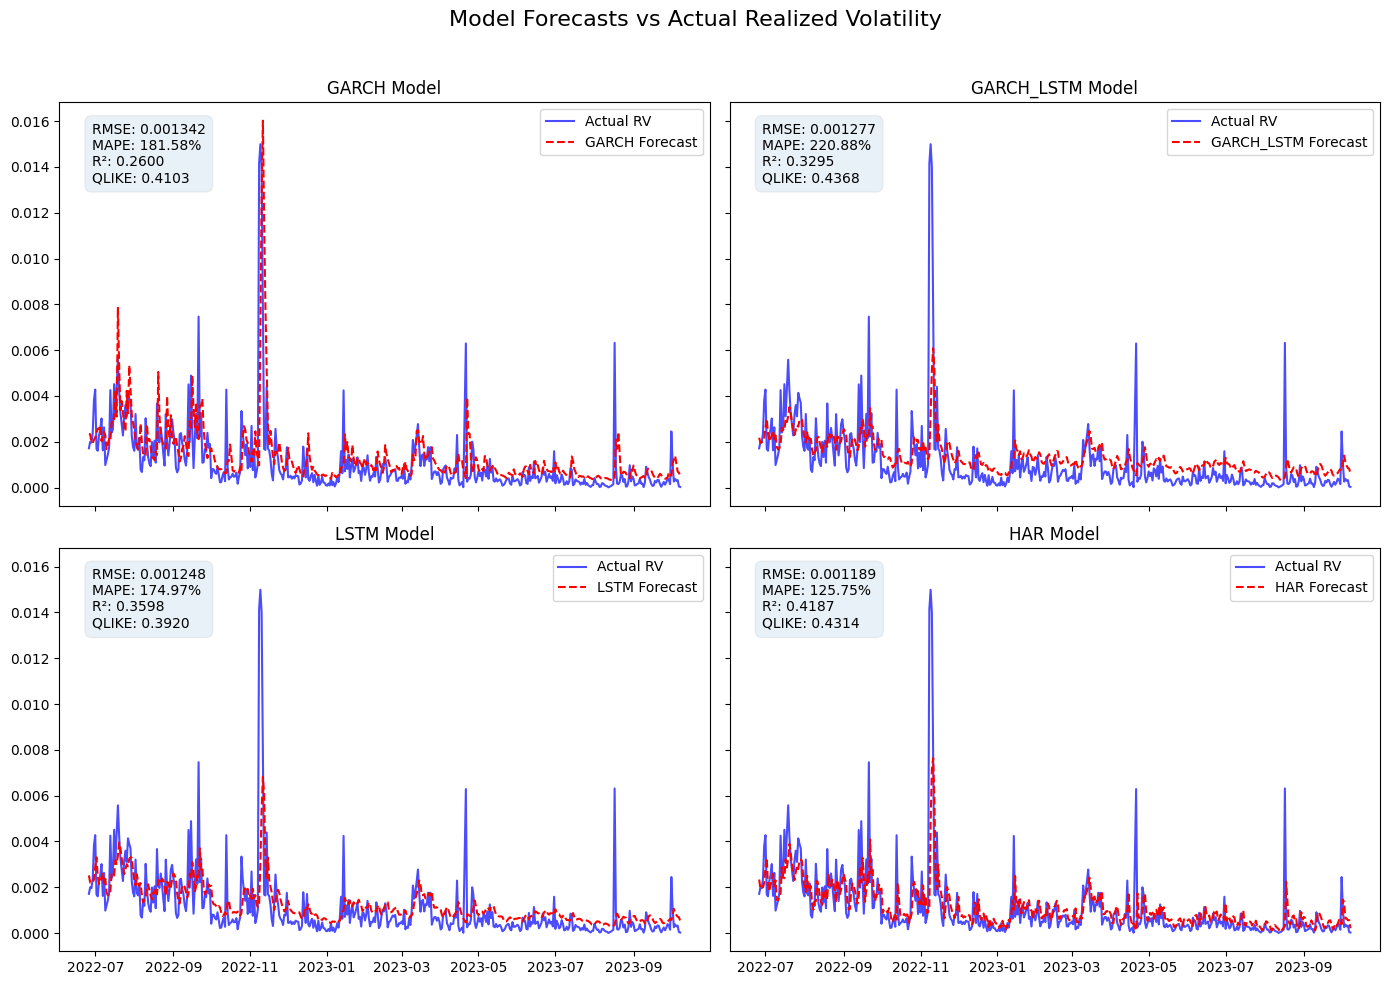

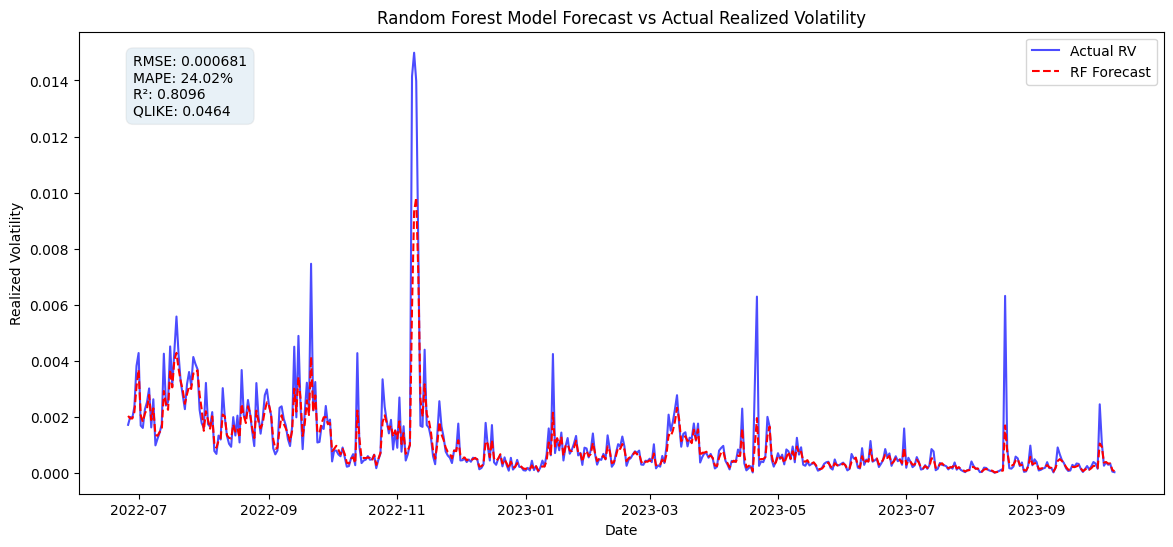

In [63]:
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Model Forecasts vs Actual Realized Volatility', fontsize=16)

# Model names for titles
model_names = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR']

# Plot each model in the 2x2 grid
for ax, model, name in zip(axs.flatten(), models[:-1], model_names):
    ax.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
    ax.plot(data.index, data[model], label=f'{name} Forecast', color='red', linestyle='dashed')
    ax.set_title(f'{name} Model')
    ax.legend()
    # Add metrics as text
    rmse, mape, r2 , qlike= metrics[model].values()
    rmse = float(rmse)
    mape = float(mape)
    r2 = float(r2)
    qlike = float(qlike)
    ax.text(0.05, 0.95, f'RMSE: {rmse:.6f}\nMAPE: {mape:.2%}\nR²: {r2:.4f} \nQLIKE: {qlike:.4f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, edgecolor='gray'))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Full-sized plot for the RF model
fig_rf, ax_rf = plt.subplots(figsize=(14, 6))
ax_rf.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
ax_rf.plot(data.index, data['RF'], label='RF Forecast', color='red', linestyle='dashed')
ax_rf.set_title('Random Forest Model Forecast vs Actual Realized Volatility')
ax_rf.set_xlabel('Date')
ax_rf.set_ylabel('Realized Volatility')
ax_rf.legend()
# Add metrics as text
rmse, mape, r2, qlike = metrics['RF'].values()
# Convert to float if they are not already
rmse = float(rmse)
mape = float(mape)
r2 = float(r2)
qlike = float(qlike)
ax_rf.text(0.05, 0.95, f'RMSE: {rmse:.6f}\nMAPE: {mape:.2%}\nR²: {r2:.4f} \nQLIKE: {qlike:.4f}',
           transform=ax_rf.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, edgecolor='gray'))

# Show plots
plt.show()
